In [1]:
%%javascript
require(["codemirror/keymap/sublime", "notebook/js/cell", "base/js/namespace"],
    function(sublime_keymap, cell, IPython) {
        cell.Cell.options_default.cm_config.keyMap = 'sublime';
        var cells = IPython.notebook.get_cells();
        for(var cl=0; cl< cells.length ; cl++){
            cells[cl].code_mirror.setOption('keyMap', 'sublime');
        }
    }
);

<IPython.core.display.Javascript object>

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import warnings
warnings.filterwarnings('ignore')
from more_itertools import chunked
from pathlib import Path
# import all samples as dictionary ...
from samples import *

In [3]:
import os
os.environ["MKL_NUM_THREADS"] = "1" 
os.environ["NUMEXPR_NUM_THREADS"] = "1" 
os.environ["OMP_NUM_THREADS"] = "1" 

In [4]:
# %matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('seaborn-white')
import seaborn as sns
import multiprocess as mp
import numpy as np
import pandas as pd
import bioframe
import cooltools
import cooler
from matplotlib.gridspec import GridSpec
import bbi
from cooltools import snipping

In [5]:
from matplotlib.colors import LogNorm
# https://stackoverflow.com/questions/48625475/python-shifted-logarithmic-colorbar-white-color-offset-to-center
class MidPointLogNorm(LogNorm):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        LogNorm.__init__(self, vmin=vmin, vmax=vmax, clip=clip)
        self.midpoint=midpoint
    def __call__(self, value, clip=None):
        result, is_scalar = self.process_value(value)
        x, y = [np.log(self.vmin), np.log(self.midpoint), np.log(self.vmax)], [0, 0.5, 1]
        return np.ma.array(np.interp(np.log(value), x, y), mask=result.mask, copy=False)

In [6]:
# Use bioframe to fetch the genomic features from the UCSC.
hg19_chromsizes = bioframe.fetch_chromsizes('hg19', as_bed=True)
hg19_cens = bioframe.fetch_centromeres('hg19')
hg19_arms = bioframe.split(hg19_chromsizes, hg19_cens, cols_points=['chrom', 'mid'])

# Select only chromosomes that are present in the cooler. 
# This step is typically not required! we call it only because the test data are reduced. 
hg19_chromsizes = hg19_chromsizes.set_index("chrom").loc[autosomal_chroms].reset_index() 
hg19_arms = hg19_arms.set_index("chrom").loc[autosomal_chroms].reset_index()
# call this to automaticly assign names to chromosomal arms:
hg19_arms = bioframe.parse_regions(hg19_arms)
hg19_arms["name"] = [f"{chrom}{arm}" for chrom in autosomal_chroms for arm in list('pq')]
hg19_arms.to_csv("hg19_arms.bed",sep="\t",index=False,header=False)

In [7]:
conditions = ['442-NT','442-IAA']
binsize = 2000
binsize_human = f"{int(binsize/1_000)}kb"

cooler_paths = {    
    '442-NT' : f'/data/alv/CTCF_degron/data/CkoCT442-NT-pool.mcool::resolutions/{binsize}',
    '442-IAA' : f'/data/alv/CTCF_degron/data/CkoCT442-IAA-pool.mcool::resolutions/{binsize}',
}
long_names = {
    '442-NT' : 'CTCFdegron-442-nontreated-pool',
    '442-IAA': 'CTCFdegron-442-auxin-pool',
}

pal = sns.color_palette('colorblind')
colors = {
    '442-NT': "#e74c3c",
    '442-IAA': pal[2],
}

clrs = {
    cond: cooler.Cooler(cooler_paths[cond]) for cond in conditions
}

In [8]:
# iterate over samples to calculate expected on:
for cond in conditions:
    lname,*_ = cooler_paths[cond].split(".mcool")
    target_exp_file = Path(f"{lname}.{binsize_human}.cis.exp.tsv")
    if target_exp_file.is_file():
        print("already exist !")
        print(target_exp_file)
        continue
    else:
        print("working on ...")
        print(cond,lname)
        ######################################
        !cooltools compute-expected \
            --nproc 4 \
            --output {target_exp_file} \
            --regions hg19_arms.bed \
            --contact-type cis \
            --balance \
            --weight-name weight \
            --ignore-diags 2 \
            {cooler_paths[cond]}
        ######################################


already exist !
/data/alv/CTCF_degron/data/CkoCT442-NT-pool.2kb.cis.exp.tsv
already exist !
/data/alv/CTCF_degron/data/CkoCT442-IAA-pool.2kb.cis.exp.tsv


In [9]:
expected_paths = {    
    '442-NT' : f'/data/alv/CTCF_degron/data/CkoCT442-NT-pool.{binsize_human}.cis.exp.tsv',
    '442-IAA' : f'/data/alv/CTCF_degron/data/CkoCT442-IAA-pool.{binsize_human}.cis.exp.tsv',
}
expecteds = {
    cond: pd.read_csv(expected_paths[cond], sep="\t") for cond in conditions
}

In [15]:
#pick the bed file to do interaction pileup on
boundaries = pd.read_table('/data/alv/CTCF_degron/analysis/for-paper/draft6/int_pileup_by_arm/masterlist_CTCFdependent.bed', delimiter='\t', names=["chrom", "start", "end","strand"])#,"score", "score2", "score3","score4","score5","score6"])
print(boundaries.head())
print(len(boundaries))

   chrom      start        end  strand
0  chr20   26189793   26190372     NaN
1  chr14   88237570   88237824     NaN
2   chr2  133015108  133015345     NaN
3  chr22   21271181   21271776     NaN
4  chr17   41399725   41401091     NaN
10000


In [19]:
#pick the bed file to do interaction pileup on
boundaries = pd.read_table('/data/alv/CTCF_degron/analysis/for-paper/draft6/int_pileup_by_arm/masterlist_CTCFindependent.bed', delimiter='\t', names=["chrom", "start", "end","strand"])#,"score", "score2", "score3","score4","score5","score6"])
print(boundaries.head())
print(len(boundaries))

   chrom      start        end  strand
0  chr22   22089705   22090414     NaN
1   chr9  123630887  123631666     NaN
2  chr22   19165638   19167351     NaN
3  chr22   20104784   20105071     NaN
4  chr22   23522606   23522844     NaN
10000


In [20]:
flank = 50000
windows = snipping.make_bin_aligned_windows(
    binsize, 
    boundaries['chrom'], 
    (boundaries['start'] + boundaries['end'])//2,
    flank_bp=flank)
windows = snipping.assign_regions(windows, hg19_arms)
windows = windows.dropna()
arm_sites = boundaries.loc[windows.index,:].reset_index(drop=True)
windows = windows.reset_index(drop=True)
print(len(windows), 'windows, after assigning supports')
windows.head()

10000 windows, after assigning supports


,chrom,start,end,lo,hi,region
0,chr22,22040000,22142000,11020,11071,chr22q
1,chr9,123580000,123682000,61790,61841,chr9q
2,chr22,19116000,19218000,9558,9609,chr22q
3,chr22,20054000,20156000,10027,10078,chr22q
4,chr22,23472000,23574000,11736,11787,chr22q


In [21]:
# the most time consuming step !!!
stacks = {}
piles = {}
for cond in conditions:
    snipper = snipping.ObsExpSnipper(clrs[cond], expecteds[cond], regions=hg19_arms)
    stack = snipping.pileup(windows, snipper.select, snipper.snip)
    stacks[cond] = stack
    piles[cond] = np.nanmean(stack, axis=2)

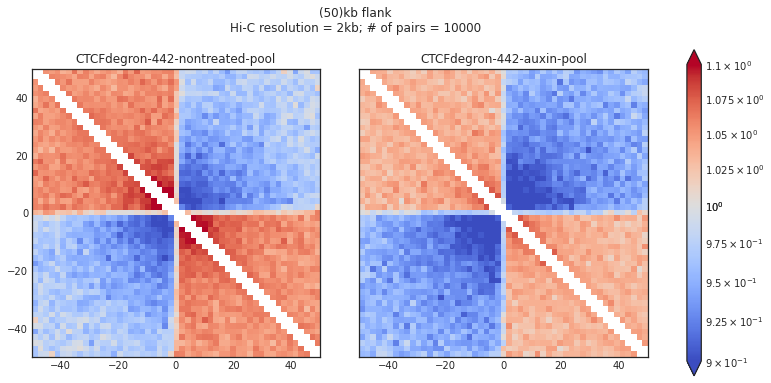

In [22]:
# draw the pileup
gs = plt.GridSpec(nrows=1, ncols=len(conditions) + 1, width_ratios=[20] * len(conditions) + [1])
fig = plt.figure(figsize=(6 * len(conditions), 6))

opts = dict(
    norm = MidPointLogNorm(vmin=0.9,vmax=1.1,midpoint=1),
    extent=[-flank//1000, flank//1000, -flank//1000, flank//1000],
#     cmap='RdBu_r',
    cmap='coolwarm',
    interpolation="nearest"
)

for i, cond in enumerate(conditions):
    ax = plt.subplot(gs[i])
    img = ax.matshow(
        piles[cond],
        **opts)
    ax.xaxis.tick_bottom()
    if i > 0:
        ax.yaxis.set_visible(False)
    plt.title(long_names[cond])

ax = plt.subplot(gs[len(conditions)])
plt.colorbar(img, cax=ax, extend = 'both')

plt.suptitle(f'({flank//1000})kb flank\n'
             f'Hi-C resolution = {binsize//1000}kb; # of pairs = {len(windows)}')

fig.savefig("/data/alv/CTCF_degron/analysis/for-paper/draft6/int_pileup_by_arm/fig1-int-pileup-CTCFindep-50kb-byarm.pdf", format="pdf")

In [19]:
#to convert previous scale
2 ** -0.15

0.9012504626108302